In [1]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [2]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("ProjectCaliper/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


View Calltree

In [3]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

0.753 main
└─ 0.200 main
   ├─ 0.100 comm
   │  ├─ 0.058 comm_large
   │  └─ 0.142 comm_small
   ├─ 0.141 comp
   │  ├─ 0.140 comp_large
   │  └─ 0.001 comp_small
   ├─ 0.000 correctness_check
   └─ 0.057 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.75 indices: {'profile': 223081490})
█ 0.68 - 0.75
█ 0.53 - 0.68
█ 0.38 - 0.53
█ 0.23 - 0.38
█ 0.08 - 0.23
█ 0.00 - 0.08

name User code    ◀  Only in left graph    ▶  Only in right graph



Group Performance data by `matrix_size` in the Thicket metadata table.

In [4]:
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")
tk.metadata_column_to_perfdata("algorithm")

tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size", "input_type", "algorithm"]).sort_index()

tk.dataframe

profile  \
node                                              num_procs input_size input_type    algorithm               
{'name': 'main', 'type': 'function'}              2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
                                                            256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
{'name': 'comm', 'type': 'function'}              2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
{'name': 'comm_large', 'type': 'function'}        2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
{'name': 'comm_small', 'type': 'function'}        2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
{'name': 'comp', 'type': 'function'}              2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
{'name': 'comp_large', 'type': 'function'}        2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
{'name': 'comp_small', 'type': 'function'}        2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
{'name': 'correctness_check', 'type': 'function'} 2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   
{'name': 'data_init_runtime', 'type': 'function'} 2         256        ReverseSorted column      223081490   
                                                            512        ReverseSorted column     1231686076   

                                                                                                 nid  \
node                                              num_procs input_size input_type    algorithm         
{'name': 'main', 'type': 'function'}              2         256        ReverseSorted column      1.0   
                                                            512        ReverseSorted column      1.0   
                                                            256        ReverseSorted column      2.0   
                                                            512        ReverseSorted column      2.0   
{'name': 'comm', 'type': 'function'}              2         256        ReverseSorted column      4.0   
                                                            512        ReverseSorted column      4.0   
{'name': 'comm_large', 'type': 'function'}        2         256        ReverseSorted column      6.0   
                                                            512        ReverseSorted column      6.0   
{'name': 'comm_small', 'type': 'function'}        2         256        ReverseSorted column      5.0   
                                                            512        ReverseSorted column      5.0   
{'name': 'comp', 'type': 'function'}              2         256        ReverseSorted column      7.0   
                                                            512        ReverseSorted column      7.0   
{'name': 'comp_large', 'type': 'function'}        2         256        ReverseSorted column      8.0   
                                                            512        ReverseSorted column      8.0   
{'name': 'comp

In [5]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128]
matrix_sizes = [128, 1024, 8192]

In [6]:
# Change font size for all plots
plt.rcParams.update({"font.size": 20})

In [7]:
def plot_pandas(df, title, xlabel, ylabel):
    plot = df.plot(kind="line", 
        marker='o', 
        title=title, 
        xlabel=xlabel,
        ylabel=ylabel, 
        figsize=(15,7)
    )
    return plot

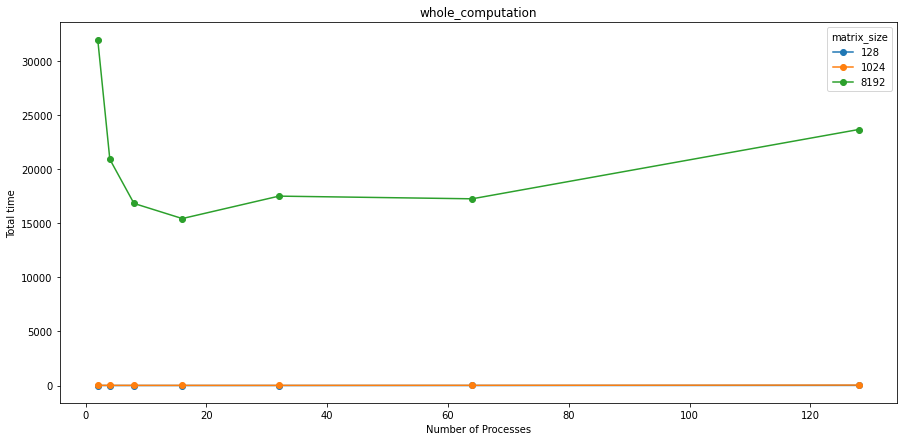

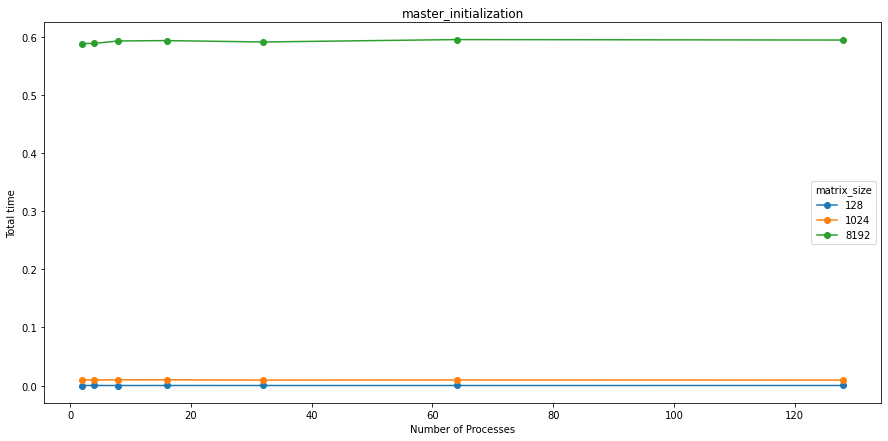

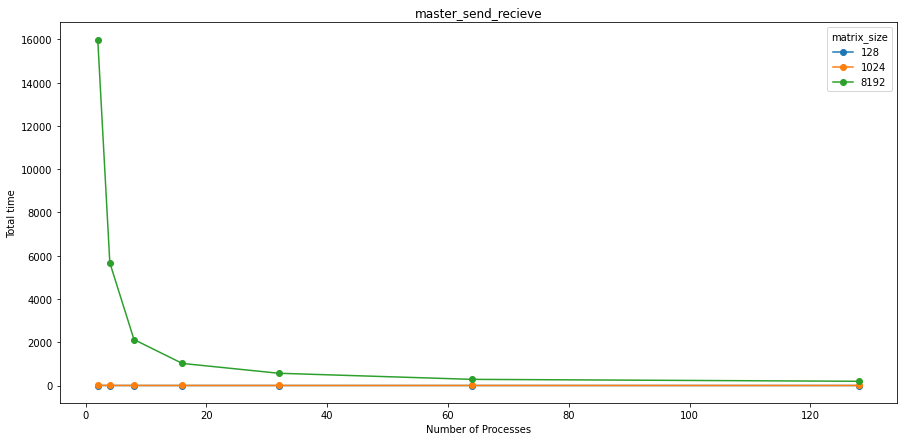

In [13]:
master = []
worker = []
for node in tk.graph.traverse():
    if node.frame['name'] == 'whole_computation' or node.frame['name'] == 'master_initialization' or node.frame['name'] == 'master_send_recieve':
        master.append(node)
    elif node.frame['name'] == 'main':
        continue
    else:
        worker.append(node)

for node in master:
    plot_pandas(
        df=tk.dataframe.loc[node, "Total time"].unstack(level="matrix_size"),
        title=node.frame["name"],
        xlabel="Number of Processes",
        ylabel="Total time",
    )

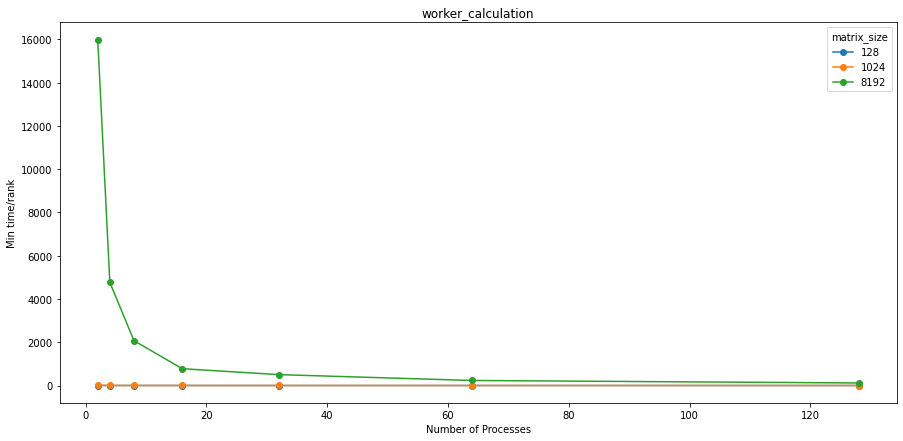

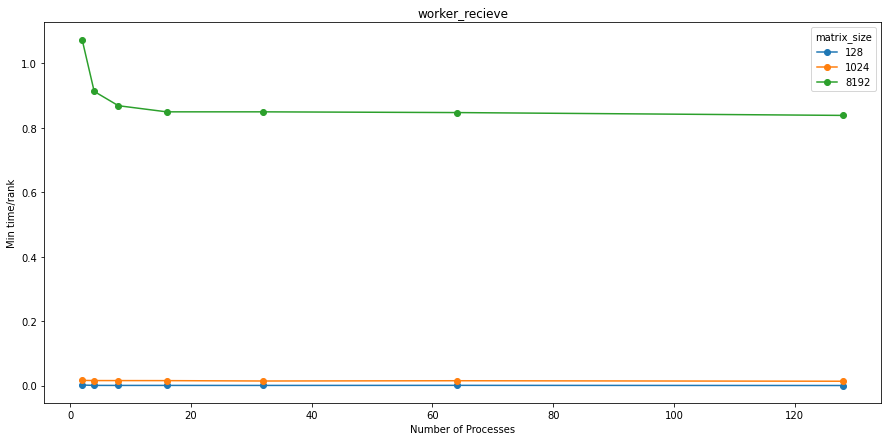

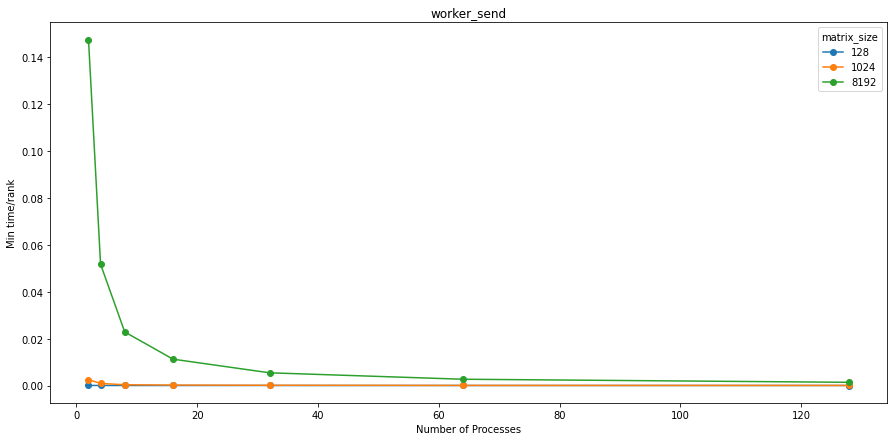

In [14]:
# Min time/rank
for node in worker:
    plot_pandas(
        df=tk.dataframe.loc[node, "Min time/rank"].unstack(level="matrix_size"),
        title=node.frame["name"],
        xlabel="Number of Processes",
        ylabel="Min time/rank",
    )

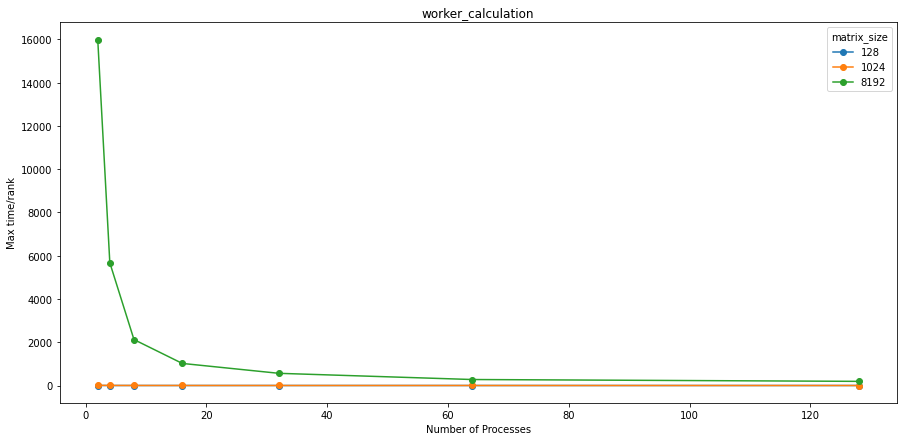

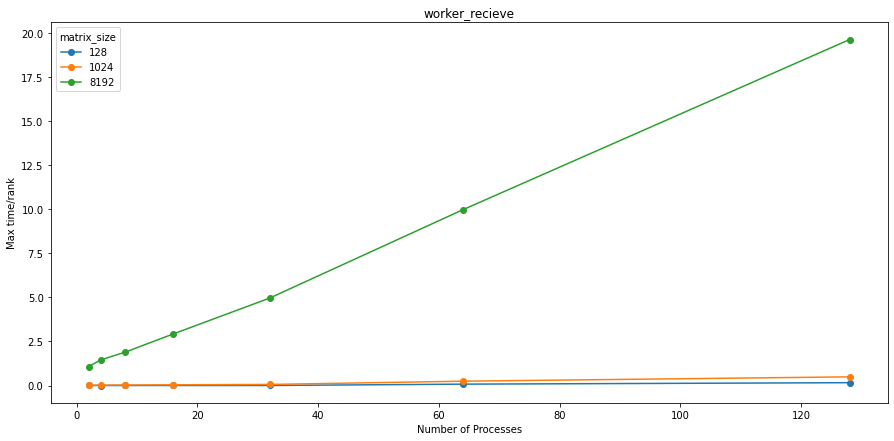

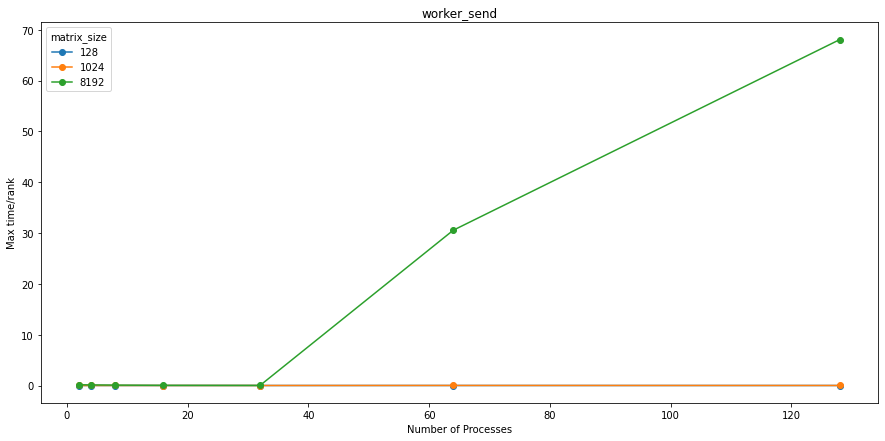

In [15]:
# Max time/rank
for node in worker:
    plot_pandas(
        df=tk.dataframe.loc[node, "Max time/rank"].unstack(level="matrix_size"),
        title=node.frame["name"],
        xlabel="Number of Processes",
        ylabel="Max time/rank",
    )

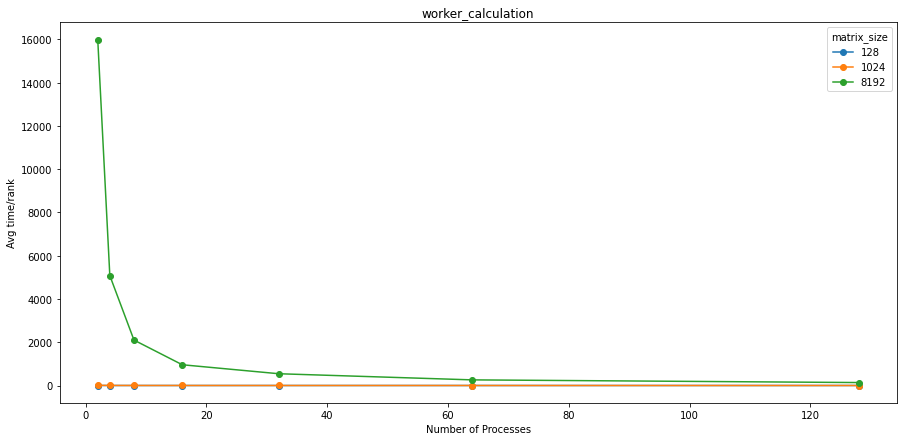

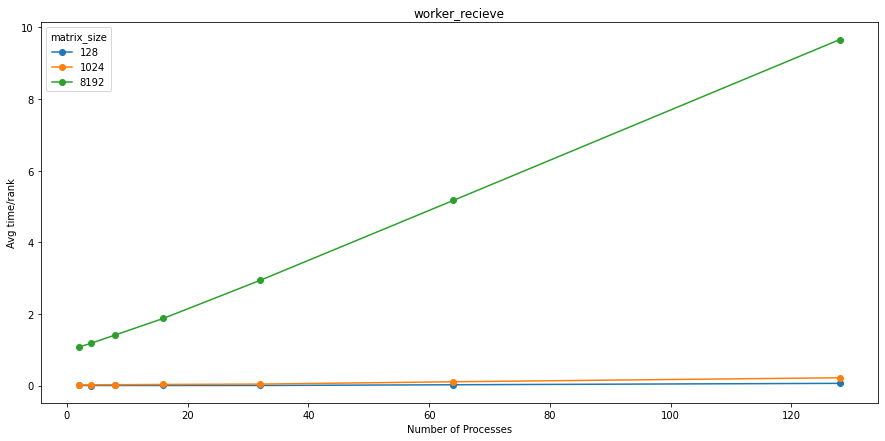

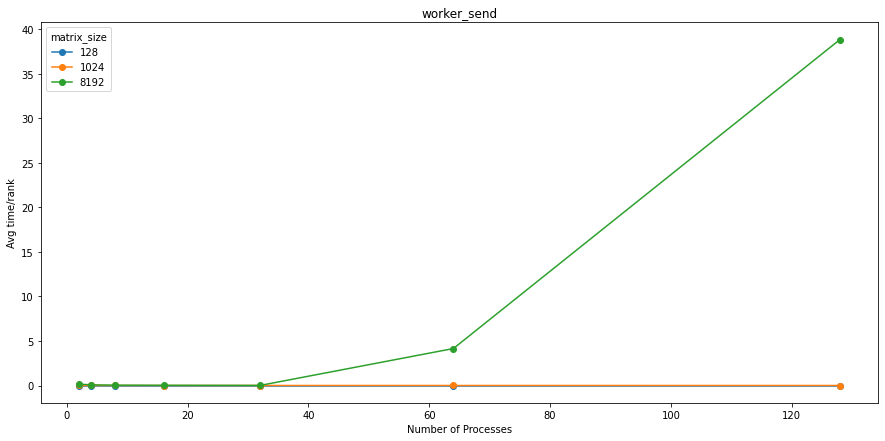

In [16]:
# Avg time/rank
for node in worker:
    plot_pandas(
        df=tk.dataframe.loc[node, "Avg time/rank"].unstack(level="matrix_size"),
        title=node.frame["name"],
        xlabel="Number of Processes",
        ylabel="Avg time/rank",
    )